#Notebook 2
This presents an alternative approach distinct from Notebook 1, incorporating corrections to mistakes found in the feature engineering process, encoding of neighborhoods, undersampling for handling imbalanced data, and dropping unnecessary features.

**Note:** However the deployment code is based on approach of Notebook-1

##Importing the required libraries

In [56]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,f1_score,make_scorer,roc_auc_score

import pickle

- - -

- - -

##Importing the data

In [57]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/Patient no show.csv')

df = data.copy()
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.990000e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.590000e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.260000e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.680000e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.840000e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


- - -

- - -

#Cleaning the data

In [58]:
#Replacing Handcap values of 2, 3, 4 to 1

df['Handcap'].replace([2, 3, 4], 1, inplace=True)

In [59]:
# Dropping rows with negative ages

df = df[df['Age'] >= 0]

In [60]:
# Using lambda function to clip ages under 100

df.loc[:,'Age'] = df['Age'].apply(lambda x: min(100, x))

- - -

- - -

##Preprocessing and Feature Engineering

In [61]:
#Converting 'ScheduledDay' and 'AppointmentDay' to pandas datetime

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])


In [62]:
#Creating Date_of_Reg (Date of Registration Column) and Date_of_App (Date of appointment) with Date alone
#Similarly we are creating month, day, and week number feature for each column

df['Date_of_Reg'] = df['ScheduledDay'].dt.date
df['Date_of_App'] = df['AppointmentDay'].dt.date

df['Month_of_Reg'] = df['ScheduledDay'].dt.month
df['Month_of_App'] = df['AppointmentDay'].dt.month

df['Day_of_Reg'] = df['ScheduledDay'].dt.dayofweek #where Monday is 0 and Sunday is 6
df['Day_of_App'] = df['AppointmentDay'].dt.dayofweek

In [63]:
#Number of days and month difference between Date of registration and Date of appointment

df['Diff_in_Date'] = (df['Date_of_App'] - df['Date_of_Reg']).dt.days.astype(int)
df['Diff_in_Month'] = (df['AppointmentDay'].dt.year - df['ScheduledDay'].dt.year) * 12 + (df['Month_of_App'] - df['Month_of_Reg'])

- - -

In [64]:
#Encoding the Gender and No-show column

df['No-show_encoded'] = df['No-show'].map({'Yes' : 1, 'No' : 0})
df['Gender_encoded'] = df['Gender'].map({'M' : 1, 'F' : 0})

- - -

In [65]:
#Getting count of each neighbourhood

df.groupby('Neighbourhood').size().reset_index(name='Count').sort_values(by='Count', ascending=False)

,Neighbourhood,Count
38,JARDIM CAMBURI,7717
44,MARIA ORTIZ,5805
59,RESIST?NCIA,4431
39,JARDIM DA PENHA,3877
36,ITARAR?,3514
...,...,...
31,ILHA DO BOI,35
32,ILHA DO FRADE,10
0,AEROPORTO,8
34,ILHAS OCE?NICAS DE TRINDADE,2


In [66]:
#Encoding the neighbourhood based on count
Neighbourhood_counts = Counter(df['Neighbourhood'])

# Sort Neighbourhoods by frequency
sorted_Neighbourhoods = sorted(Neighbourhood_counts, key=Neighbourhood_counts.get)

# Create a mapping of Neighbourhoods to numerical values based on count frequency
Neighbourhood_mapping = {Neighbourhood: i for i, Neighbourhood in enumerate(sorted_Neighbourhoods)}

# Map Neighbourhoods to numerical values
df['Encoded_Neighbourhood'] = df['Neighbourhood'].map(Neighbourhood_mapping)

In [67]:
df.groupby(['Neighbourhood','Encoded_Neighbourhood']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

,Neighbourhood,Encoded_Neighbourhood,Count
38,JARDIM CAMBURI,80,7717
44,MARIA ORTIZ,79,5805
59,RESIST?NCIA,78,4431
39,JARDIM DA PENHA,77,3877
36,ITARAR?,76,3514
...,...,...,...
31,ILHA DO BOI,4,35
32,ILHA DO FRADE,3,10
0,AEROPORTO,2,8
34,ILHAS OCE?NICAS DE TRINDADE,1,2


The encoded neighborhood is established by assigning numerical values to each neighborhood in the dataset. Neighborhoods with the highest counts are allocated the highest numerical values in this encoding scheme.

- - -

 - - -

#Vizualizing the corrected feature

In [68]:
#User defined function for visualizing Categorical entries

def catplot(df, x, explode = None, figsize = (20, 5)):
  colors=['#FBE7A3', '#FFFFFF', '#AED6F1', '#82E0AA', '#D8BFD8', '#E6BE8A']
  sns.set(style='white')
  fig = plt.subplots(1,3,figsize = figsize)
  title = x + ' vs No-show'
  plt.suptitle(title)

  plt.subplot(1,3,1)
  df[x].value_counts().plot.pie(explode = explode, autopct = '%1.1f%%', textprops = {'fontsize': '7'}, startangle=90, shadow=True,
                                         wedgeprops={'edgecolor': 'black'}, colors = colors)

  plt.subplot(1,3,2)
  ax = sns.countplot(data = df, x = x, color = colors[0], edgecolor = 'k')
  ax.bar_label(ax.containers[0])

  plt.subplot(1,3,3)
  colors={'No' : '#FBE7A3', 'Yes' : '#FFFFFF'}
  ax = sns.countplot(data = df, x = x, hue = 'No-show', palette = colors, edgecolor = 'k')
  for container in ax.containers:
    ax.bar_label(container)

In [69]:
#User defined function to print the loan approval rate for each unique value in a specified column

def showup_rate(df, col_name):
  unique = df[col_name].unique()
  unique.sort()
  for i in unique:
    total = df[df[col_name] == i].shape[0]
    showup = df[(df[col_name] == i) & (df['No-show'] == 'No') ].shape[0]
    rate = (showup / total)*100
    print('Show up rate for "{0} : {1}" patients is {2:.2f}%'.format(col_name,i , rate))

- - -

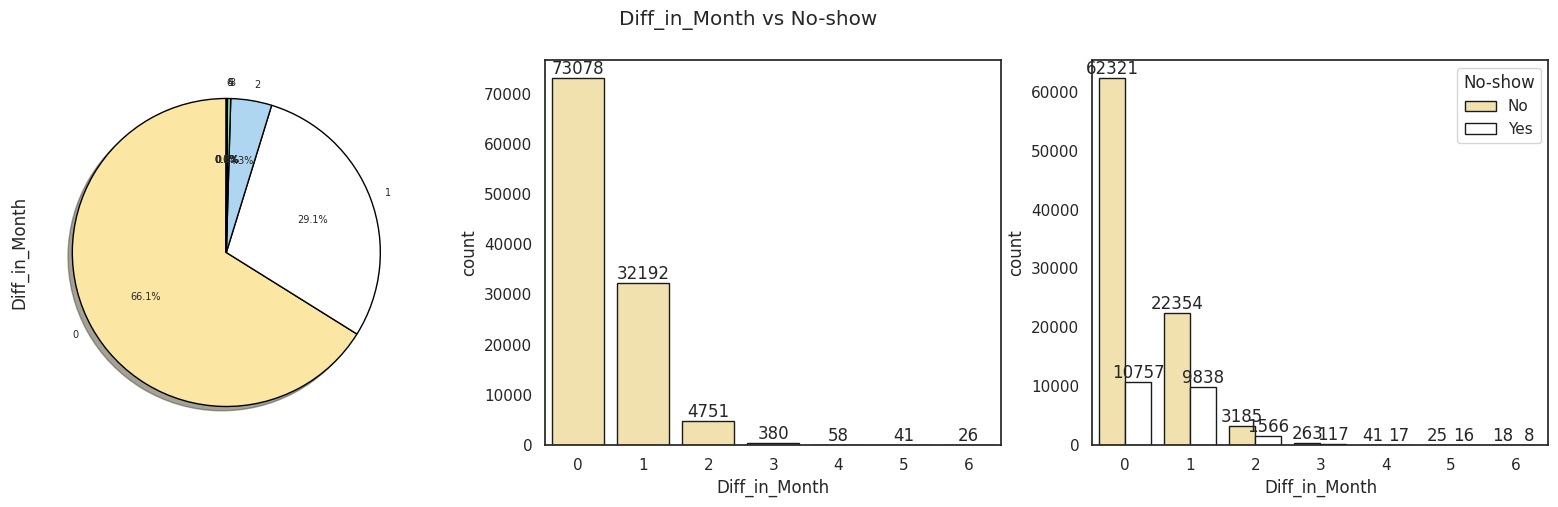

In [70]:
catplot(df, 'Diff_in_Month')

In [71]:
showup_rate(df, 'Diff_in_Month')

Show up rate for "Diff_in_Month : 0" patients is 85.28%
Show up rate for "Diff_in_Month : 1" patients is 69.44%
Show up rate for "Diff_in_Month : 2" patients is 67.04%
Show up rate for "Diff_in_Month : 3" patients is 69.21%
Show up rate for "Diff_in_Month : 4" patients is 70.69%
Show up rate for "Diff_in_Month : 5" patients is 60.98%
Show up rate for "Diff_in_Month : 6" patients is 69.23%



The summary of the provided show-up rates for different "Diff_in_Month" categories indicates that the majority of patients have either a 0 or 1-month difference. The show-up rate is notably high at 85.28% for a month difference of 0 but decreases significantly to 69.44% for a one-month difference.

- - -

- - -

##Splitting the train and test

In [72]:
No_show_df = df[df['No-show'] == 'Yes']
Showed_up_df = df[df['No-show'] == 'No']

In [73]:
# Shuffle the DataFrame to ensure randomness in the splits

No_show_df = No_show_df.sample(frac=1, random_state=42).reset_index(drop=True)
Showed_up_df = Showed_up_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [74]:
# Determine the number of rows for each part

total_rows_no_show = len(No_show_df)
total_rows_showed_up = len(Showed_up_df)

In [75]:
train_size = int(0.7 * total_rows_no_show)
test_size = int(0.15 * total_rows_no_show)
val_size = total_rows_no_show - train_size - test_size

# Split No_show_df into three parts
train_no_show = No_show_df.iloc[:train_size].reset_index(drop=True)
test_no_show = No_show_df.iloc[train_size:train_size + test_size].reset_index(drop=True)
val_no_show = No_show_df.iloc[train_size + test_size:].reset_index(drop=True)

In [76]:
# Similarly, determine the sizes for Showed_up_df
train_size = int(0.7 * total_rows_showed_up)
test_size = int(0.15 * total_rows_showed_up)
val_size = total_rows_showed_up - train_size - test_size

# Split Showed_up_df into three parts
train_showed_up = Showed_up_df.iloc[:train_size].reset_index(drop=True)
test_showed_up = Showed_up_df.iloc[train_size:train_size + test_size].reset_index(drop=True)
val_showed_up = Showed_up_df.iloc[train_size + test_size:].reset_index(drop=True)

In [77]:
train_df = pd.concat([train_no_show, train_showed_up], ignore_index=True)
test_df = pd.concat([test_no_show, test_showed_up], ignore_index=True)
val_df = pd.concat([val_no_show, val_showed_up], ignore_index=True)

- - -
- - -

##Splitting the dependent and independent

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77367 entries, 0 to 77366
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   PatientId              77367 non-null  float64            
 1   AppointmentID          77367 non-null  int64              
 2   Gender                 77367 non-null  object             
 3   ScheduledDay           77367 non-null  datetime64[ns, UTC]
 4   AppointmentDay         77367 non-null  datetime64[ns, UTC]
 5   Age                    77367 non-null  int64              
 6   Neighbourhood          77367 non-null  object             
 7   Scholarship            77367 non-null  int64              
 8   Hipertension           77367 non-null  int64              
 9   Diabetes               77367 non-null  int64              
 10  Alcoholism             77367 non-null  int64              
 11  Handcap                77367 non-null  int64          

In [79]:
X_train = train_df.iloc[:,[5,7,8,9,10,11,12,19,20,21,23,24]]
X_test = test_df.iloc[:,[5,7,8,9,10,11,12,19,20,21,23,24]]
X_val = val_df.iloc[:,[5,7,8,9,10,11,12,19,20,21,23,24]]

y_train = train_df.iloc[:,22].values
y_test = test_df.iloc[:,22].values
y_val = val_df.iloc[:,22].values

- - -
- - -

#Handling imbalanced data

In [80]:
# Create an instance of NearMiss-3

nm = NearMiss(version=3)
X_train_resampled, y_train_resampled = nm.fit_resample(X_train, y_train)

In [81]:
print("Before UnderSampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label 'No': {}".format(sum(y_train == 0)))

print("After UnderSampling, counts of label 'Yes': {}".format(sum(y_train_resampled == 1)))
print("After UnderSampling, counts of label 'No': {}".format(sum(y_train_resampled == 0)))

Before UnderSampling, counts of label 'Yes': 15623
Before UnderSampling, counts of label 'No': 61744
After UnderSampling, counts of label 'Yes': 15623
After UnderSampling, counts of label 'No': 15623


- - -
- - -

#Model Fitting (MLP) and Evaluation

Model fitting

In [82]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
classifier.fit(X_train_resampled, y_train_resampled)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

Evaluation metrics

In [83]:
print('Metrics for train data inputed in the model:\n')
y_train_resampled_pred = classifier.predict(X_train_resampled)
print("Accuracy score:", accuracy_score(y_train_resampled, y_train_resampled_pred))
print("Precision score:", precision_score(y_train_resampled, y_train_resampled_pred))
print("Recall score:", recall_score(y_train_resampled, y_train_resampled_pred))
print("F1 score:", f1_score(y_train_resampled, y_train_resampled_pred))
print("\nClassification report:\n", classification_report(y_train_resampled, y_train_resampled_pred))
print("Confusion matrix:\n", confusion_matrix(y_train_resampled, y_train_resampled_pred))

Metrics for train data inputed in the model:

Accuracy score: 0.6097100428854894
Precision score: 0.626401179941003
Recall score: 0.5436855917557447
F1 score: 0.5821197272384606

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.68      0.63     15623
           1       0.63      0.54      0.58     15623

    accuracy                           0.61     31246
   macro avg       0.61      0.61      0.61     31246
weighted avg       0.61      0.61      0.61     31246

Confusion matrix:
 [[10557  5066]
 [ 7129  8494]]


In [84]:
print('Metrics for test data:\n')
y_pred = classifier.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Metrics for test data:

Accuracy score: 0.4458921462178791
Precision score: 0.1914826165063933
Recall score: 0.5413803406035256
F1 score: 0.282903981264637

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.42      0.55     13231
           1       0.19      0.54      0.28      3347

    accuracy                           0.45     16578
   macro avg       0.49      0.48      0.42     16578
weighted avg       0.66      0.45      0.49     16578

Confusion matrix:
 [[5580 7651]
 [1535 1812]]


In [85]:
print('Metrics for validation data\n')
y_val_pred = classifier.predict(X_val)
print("Accuracy score:", accuracy_score(y_val, y_val_pred))
print("Precision score:", precision_score(y_val, y_val_pred))
print("Recall score:", recall_score(y_val, y_val_pred))
print("F1 score:", f1_score(y_val, y_val_pred))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))

Metrics for validation data

Accuracy score: 0.4440624811531271
Precision score: 0.18924070740230858
Recall score: 0.5335921170498656
F1 score: 0.2793933708567855

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.42      0.55     13232
           1       0.19      0.53      0.28      3349

    accuracy                           0.44     16581
   macro avg       0.49      0.48      0.41     16581
weighted avg       0.66      0.44      0.49     16581

Confusion matrix:
 [[5576 7656]
 [1562 1787]]


- - -

##Result:


In summary, the MLP model shows moderate accuracy and balanced metrics on both training and test sets, suggesting room for improvement via feature engineering and hyperparameter tuning.

- - -

- - -

##Model fitting and evaluation after scaling

Scaling

In [86]:
sc = StandardScaler()
X_train_resampled_sc = sc.fit_transform(X_train_resampled)
X_test_sc = sc.transform(X_test)
X_val_sc = sc.transform(X_val)

Model Fitting

In [87]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
classifier.fit(X_train_resampled_sc, y_train_resampled)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

Evaluation metrics

In [88]:
print('Metrics for train data inputed in the model:\n')
y_train_resampled_pred = classifier.predict(X_train_resampled_sc)
print("Accuracy score:", accuracy_score(y_train_resampled, y_train_resampled_pred))
print("Precision score:", precision_score(y_train_resampled, y_train_resampled_pred))
print("Recall score:", recall_score(y_train_resampled, y_train_resampled_pred))
print("F1 score:", f1_score(y_train_resampled, y_train_resampled_pred))
print("\nClassification report:\n", classification_report(y_train_resampled, y_train_resampled_pred))
print("Confusion matrix:\n", confusion_matrix(y_train_resampled, y_train_resampled_pred))

Metrics for train data inputed in the model:

Accuracy score: 0.6914485054086923
Precision score: 0.7352524775837659
Recall score: 0.5983485886193433
F1 score: 0.659773441084095

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.72     15623
           1       0.74      0.60      0.66     15623

    accuracy                           0.69     31246
   macro avg       0.70      0.69      0.69     31246
weighted avg       0.70      0.69      0.69     31246

Confusion matrix:
 [[12257  3366]
 [ 6275  9348]]


In [89]:
print('Metrics for test data:\n')
y_pred = classifier.predict(X_test_sc)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Metrics for test data:

Accuracy score: 0.47834479430570637
Precision score: 0.19283810406767876
Recall score: 0.4971616372871228
F1 score: 0.27788911155644624

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.47      0.59     13231
           1       0.19      0.50      0.28      3347

    accuracy                           0.48     16578
   macro avg       0.49      0.49      0.43     16578
weighted avg       0.67      0.48      0.53     16578

Confusion matrix:
 [[6266 6965]
 [1683 1664]]


In [90]:
print('Metrics for validation data\n')
y_val_pred = classifier.predict(X_val_sc)
print("Accuracy score:", accuracy_score(y_val, y_val_pred))
print("Precision score:", precision_score(y_val, y_val_pred))
print("Recall score:", recall_score(y_val, y_val_pred))
print("F1 score:", f1_score(y_val, y_val_pred))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))

Metrics for validation data

Accuracy score: 0.4727097280019299
Precision score: 0.18878375259635358
Recall score: 0.488504031054046
F1 score: 0.2723262588431128

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.47      0.59     13232
           1       0.19      0.49      0.27      3349

    accuracy                           0.47     16581
   macro avg       0.49      0.48      0.43     16581
weighted avg       0.66      0.47      0.52     16581

Confusion matrix:
 [[6202 7030]
 [1713 1636]]


- - -

##Result

After scaling the data, the MLP model demonstrates a slight improvement in accuracy compared to the non-scaled version, achieving an accuracy of just 69%.

- - -

- - -

#Random Forest to find feature importance

Model fitting

In [91]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

Evaluation metrics

In [92]:
print('Metrics for train data inputed in the model:\n')
y_train_resampled_pred = classifier.predict(X_train_resampled)
print("Accuracy score:", accuracy_score(y_train_resampled, y_train_resampled_pred))
print("Precision score:", precision_score(y_train_resampled, y_train_resampled_pred))
print("Recall score:", recall_score(y_train_resampled, y_train_resampled_pred))
print("F1 score:", f1_score(y_train_resampled, y_train_resampled_pred))
print("\nClassification report:\n", classification_report(y_train_resampled, y_train_resampled_pred))
print("Confusion matrix:\n", confusion_matrix(y_train_resampled, y_train_resampled_pred))

Metrics for train data inputed in the model:

Accuracy score: 0.9984638033668309
Precision score: 0.9992307199179434
Recall score: 0.9976957050502464
F1 score: 0.9984626225097688

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15623
           1       1.00      1.00      1.00     15623

    accuracy                           1.00     31246
   macro avg       1.00      1.00      1.00     31246
weighted avg       1.00      1.00      1.00     31246

Confusion matrix:
 [[15611    12]
 [   36 15587]]


In [93]:
print('Metrics for test data:\n')
y_pred = classifier.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Metrics for test data:

Accuracy score: 0.47979249607914104
Precision score: 0.21211129296235678
Recall score: 0.5808186435613982
F1 score: 0.31074168797953966

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.45      0.58     13231
           1       0.21      0.58      0.31      3347

    accuracy                           0.48     16578
   macro avg       0.51      0.52      0.45     16578
weighted avg       0.69      0.48      0.53     16578

Confusion matrix:
 [[6010 7221]
 [1403 1944]]


In [94]:
print('Metrics for validation data:\n')
y_val_pred = classifier.predict(X_val)
print("Accuracy score:", accuracy_score(y_val, y_val_pred))
print("Precision score:", precision_score(y_val, y_val_pred))
print("Recall score:", recall_score(y_val, y_val_pred))
print("F1 score:", f1_score(y_val, y_val_pred))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))

Metrics for validation data:

Accuracy score: 0.4867016464628189
Precision score: 0.21303090949521902
Recall score: 0.5721110779337115
F1 score: 0.31045936968322124

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.47      0.59     13232
           1       0.21      0.57      0.31      3349

    accuracy                           0.49     16581
   macro avg       0.51      0.52      0.45     16581
weighted avg       0.69      0.49      0.53     16581

Confusion matrix:
 [[6154 7078]
 [1433 1916]]


Feature importance

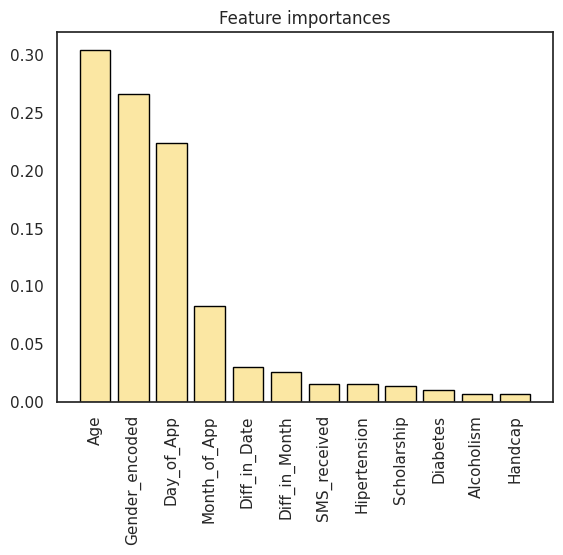

In [95]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

X_df = train_df.iloc[:,[5,7,8,9,10,11,12,17,19,20,21,23,24]]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="#FBE7A3", align="center", edgecolor="black")
plt.xticks(range(X_train.shape[1]), X_df.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

- - -

##Result:

The Random Forest model achieves near-perfect accuracy on training data but faces challenges in generalization, necessitating regularization and model evaluation for real-world applicability. Age, Neighbourhood and Diff_in_Date are the top 3 important features according to random forest classifier.

- - -

- - -